# This script is for Plotting Maccor Data

## How do I grab the Maccor data?

That's the nice thing about *this* script is that the script will do this automatically by opening a window where your data is and allowing you to select it. 

## How should the format be for the files?

There shouldn't be a need to worry about that. The files come from the maccor directly before being converted to a form that is readable for anything that is not maccor.

If you want to read something outside the server, here is what it should look like
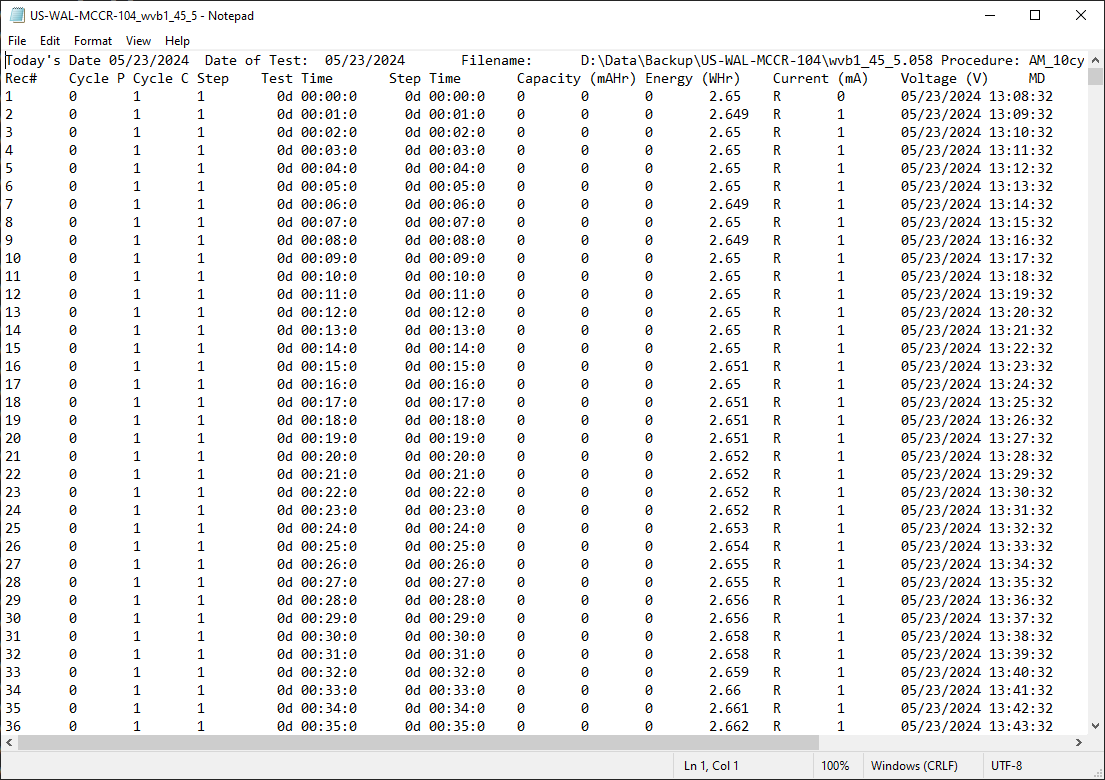

NOTE! There are more columns not shown, the most important thing is to be mindful of the number of lines (rows) above the headers.

## WAIT! I want to grab my data by hand because I need to be fancy
See ici_analysis.ipynb for instructions

## How do I use this script? I don't know any coding...

No problem, if you can hit Shift+Enter and type into prompts then you are fine.

### Step 1

You should see a blue bar to the left of this text, this refers to which part of the code the system will read next. To have the system read the code, just hit Shift+Enter and it will go to the next "Cell"

### Step 2

Each cell will have a Blurb at the top with a # before it, this is meant to tell you what the cell is doing. There are some cells that you don't need to worry about changing and others that only need very minor input.

Read the blurb, if it says "#Don't worry about it", then just hit Shift+Enter

You can tell if the cell is done running by either an output such as a number or plot OR it will read "DONE"


In [ ]:
#Don't worry about it, just hit Shift+Enter

#Author: Wess van den Bergh
#Date Modified: July 8, 2024
#Environment: v2_Pharmakinetics
#Verified By:

########NOTES

# Add dQ/dV plotting + 3D plots of dQ/dV to ID points of decay
# possibly add a theoretical limit to remove erroneous or bad cycles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cmcrameri as cmc
import warnings
import os
import sys
from tkinter import*
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def import_teamed_maccor_data():
    """
    grabs the necessary maccor files either from the ASCII server or the txt files
    Also asks user for mass values and how things are grouped
    """
    
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call("wm", "attributes", ".", "-topmost", True)
        
    from tkinter import filedialog
    infiles = filedialog.askopenfilename(multiple=True, initialdir = r'\\us-wal-bat-mim1\Data\ASCIIfiles')
    
    %gui tk
    
    custom_labels = pd.DataFrame(columns = ['filepath', 'label', 'team'])
    custom_labels = pd.concat([custom_labels, pd.DataFrame([{} for _ in range(len(infiles))])], ignore_index=True)

    for i,path in enumerate(infiles): 
        custom_labels.loc[i, 'filepath'] = path
        filename = os.path.basename(path)
        custom_labels.loc[i, 'label'] = str(input("Enter a label for {}: ".format(filename)))
        custom_labels.loc[i, 'mass'] = float(input("What is the mass of {} in mg? ".format(filename)))
        
        if len(infiles) != 1:
            custom_labels.loc[i, 'team'] = (input("GROUP/CONDITION name for {} -- ENSURE THE NAMES MATCH: ".format(custom_labels.iloc[i]['label'])))
        else:
             custom_labels.loc[i, 'team'] = custom_labels.loc[i, 'label']
    
    print(custom_labels)
    return custom_labels

def find_maccor_header_txt(file_path):
    """
    opens the file and checks the first ten rows to see where the headers and data really begins, 
    this makes it agnostic to the source of the data
    """
    with open(file_path, 'r') as file:
        rows = []
        for i in range(10):
            line = file.readline()
            if not line:
                raise("End of file and header not found")
            if 'Rec#\tCycle P\t' in line:
                return i #row number to start at for the headers
            if i == 10:
                raise("Checked first ten rows, no header found")

def plot_chargedischarge(custom_labels, 
                         cell = 0, 
                         cycles_to_show = [], 
                         cycle_to_show_interval = False,
                         ax_font_size = 14,
                         point_size = 7,
                         line_width = 2,
                         title_font_size = 10,
                         title_pos = "left", 
                         theoretical_limit = 270):
    
    """
    plots one cell for charge-discharge curves with some modification parameters
    """

    #check the header location and load the cell
    maccor_header_line_number = find_maccor_header_txt(custom_labels.iloc[cell]["filepath"])
    temp_data = pd.read_csv(custom_labels.iloc[cell]['filepath'], sep = '\t', skiprows = maccor_header_line_number, header = 0)
        
    if not not cycles_to_show: #if cycles_to_show has values, kill me for the double not but it wasn't behavior earlier
        if cycle_to_show_interval == False:
            temp_data = temp_data[temp_data['Cycle P'].isin(cycles_to_show)]
        elif cycle_to_show_interval == True:
            temp_data = temp_data[temp_data['Cycle P'] % cycles_to_show[0] == 0]
    elif not cycles_to_show == True:
        pass
    
    temp_data['Capacity (mAHr)'] = temp_data['Capacity (mAHr)'].apply(lambda a: (a / custom_labels.iloc[cell]['mass']) * 1000)
    temp_data.rename(columns = {'Capacity (mAHr)': 'mAh g-1'}, inplace = True)
    
    temp_data_ch = temp_data[temp_data['MD'] == 'C']
    temp_data_dis = temp_data[temp_data['MD'] == 'D']
    
    temp_data_ch_grouped = temp_data_ch.groupby(['Cycle P'])
    temp_data_dis_grouped = temp_data_dis.groupby(['Cycle P'])
    
    fig1, ax1 = plt.subplots(figsize = (8,6))
    
    for name, group in temp_data_ch_grouped:
        plot = ax1.plot(group['mAh g-1'], group['Voltage (V)'], 
                        marker = '^', markersize = point_size,  lw = line_width, 
                        color = cmc.cm.batlow(name[0]/(temp_data_ch_grouped['Cycle P'].max().max()) * 0.8)) 
        #the color calculation is super scuffed but I cant think of a better way to do it right now, god forgive my sins
    
    for name, group in temp_data_dis_grouped:
        ax1.plot(group['mAh g-1'], group['Voltage (V)'], 
                 marker = 'v', markersize = point_size, lw = line_width, 
                 color = cmc.cm.batlow(name[0]/(temp_data_ch_grouped['Cycle P'].max().max()) * 0.8))
        #the color calculation is super scuffed but I cant think of a better way to do it right now, god forgive my sins
    
    
    plt.xlabel('Capacity (mAh/g)',  fontsize = ax_font_size, fontweight = 'bold')
    plt.ylabel('Voltage (V)',  fontsize = ax_font_size, fontweight = 'bold')
    plt.xticks(fontsize = ax_font_size, fontweight='bold')
    plt.yticks(fontsize = ax_font_size, fontweight='bold')
    
    plt.title(custom_labels.iloc[cell]["label"], fontsize = title_font_size, loc = title_pos, fontweight = 'bold')
    
    plt.tick_params(axis='both', direction='in', length=10)  # Set the length of tick marks
    
    plt.box(True)
    plt.gca().spines['top'].set_linewidth(4)    # Set top spine thickness
    plt.gca().spines['bottom'].set_linewidth(4) # Set bottom spine thickness
    plt.gca().spines['left'].set_linewidth(4)   # Set left spine thickness
    plt.gca().spines['right'].set_linewidth(4)  # Set right spine thickness

    
    norm = Normalize(vmin = 0, vmax = temp_data_ch_grouped['Cycle P'].max().max() * (1/0.8))
    cmap = cmc.cm.batlow

    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    
    
    axins1 = inset_axes(ax1, width='20%', height='5%', loc = "lower center", borderpad = 1)
    
    cbar = fig1.colorbar(sm, cax=axins1, orientation = 'horizontal', ticks = [temp_data_ch_grouped['Cycle P'].min().min(),temp_data_ch_grouped['Cycle P'].max().max()])
    axins1.set_xticklabels([str(temp_data_ch_grouped['Cycle P'].min().min()), str(temp_data_ch_grouped['Cycle P'].max().max())], fontweight = 'bold')
    axins1.xaxis.set_ticks_position('top')
    axins1.xaxis.set_label_position('top')
    cbar.set_label('Cycle', fontweight = 'bold')
     
    
def plot_voltagetime(custom_labels, 
                     cell = 0, 
                     cycles_to_show = [], 
                     cycle_to_show_interval = False,
                     ax_font_size = 14,
                     point_size = 7,
                     line_width = 2,
                     title_font_size = 10,
                     title_pos = "left", 
                     add_timelimit = [],
                     add_voltagelimit = []):
    
    """
    plots one cell for voltage vs time curves with some modification parameters
    """   
        
    #check the header location and load the cell
    maccor_header_line_number = find_maccor_header_txt(custom_labels.iloc[cell]["filepath"])
    temp_data = pd.read_csv(custom_labels.iloc[cell]['filepath'], sep = '\t', skiprows = maccor_header_line_number, header = 0)        
    
    if not not cycles_to_show: #if cycles_to_show has values, kill me for the double not but it wasn't behavior earlier
        if cycle_to_show_interval == False:
            temp_data = temp_data[temp_data['Cycle P'].isin(cycles_to_show)]
        elif cycle_to_show_interval == True:
            temp_data = temp_data[temp_data['Cycle P'] % cycles_to_show[0] == 0]
    
    
    temp_data['Test Time'] = pd.to_timedelta(temp_data['Test Time'])
    temp_data['Test Time'] = temp_data['Test Time'].dt.total_seconds() / 3600
    
    fig1, ax1 = plt.subplots(figsize = (8,6))
    
    temp_data_grouped = temp_data.groupby(['Cycle P'])
        
    for name, group in temp_data_grouped:
        plot = ax1.plot(group['Test Time'], group['Voltage (V)'], 
                        marker = '.', markersize = point_size, lw = line_width, 
                        color = cmc.cm.batlow(name[0]/(temp_data_grouped['Cycle P'].max().max()) * 0.8)) 
        #the color calculation is super scuffed but I cant think of a better way to do it right now, god forgive my sins
    
    
    plt.xlabel('Time (Hr)',  fontsize = ax_font_size, fontweight = 'bold')
    plt.ylabel('Voltage (V)',  fontsize = ax_font_size, fontweight = 'bold')
    plt.xticks(fontsize=ax_font_size, fontweight='bold')
    plt.yticks(fontsize=ax_font_size, fontweight='bold')
    
    plt.title(custom_labels.iloc[cell]["label"], fontsize = title_font_size, loc = title_pos, fontweight = 'bold')
    
    plt.tick_params(axis='both', direction='in', length=10)  # Set the length of tick marks
    
    plt.box(True)
    plt.gca().spines['top'].set_linewidth(4)    # Set top spine thickness
    plt.gca().spines['bottom'].set_linewidth(4) # Set bottom spine thickness
    plt.gca().spines['left'].set_linewidth(4)   # Set left spine thickness
    plt.gca().spines['right'].set_linewidth(4)  # Set right spine thickness
    
    norm = Normalize(vmin = 0, vmax = temp_data_grouped['Cycle P'].max().max() * (1/0.8))
    cmap = cmc.cm.batlow

    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    
    
    axins1 = inset_axes(ax1, width='20%', height='5%', loc = "lower center", borderpad = 1)
    
    cbar = fig1.colorbar(sm, cax=axins1, 
                         orientation = 'horizontal', 
                         ticks = [temp_data_grouped['Cycle P'].min().min(),temp_data_grouped['Cycle P'].max().max()])
    axins1.set_xticklabels([str(temp_data_grouped['Cycle P'].min().min()), str(temp_data_grouped['Cycle P'].max().max())], fontweight = 'bold')
    axins1.xaxis.set_ticks_position('top')
    axins1.xaxis.set_label_position('top')
    cbar.set_label('Cycle', fontweight = 'bold')
    
    
    if add_timelimit:  #if cycles_to_show has values, kill me for the double not
        ax1.set_xlim(add_timelimit)
        
    if add_voltagelimit:
        ax1.set_ylim(add_voltagelimit)
        
       
        
def plot_cyclecapacity(custom_labels, 
                       add_ch_plot = True,
                       ax_font_size = 14,
                       point_size = 7,
                       line_width = 2,
                       title_font_size = 10,
                       title_pos = "left", 
                       y_lims = [], 
                       storage_metric = "capacity"):
    
    """
    plots cells and gives errorbars based on their groupings, also has some options of plotting
    """   

    fig1, ax1 = plt.subplots(figsize = (8,6))
    
    custom_labels_sorted = custom_labels.sort_values(by = 'team')
    unique_teams = custom_labels_sorted['team'].unique()
    
    for team in unique_teams:

        try:
            del temp_data_dis_compiled, temp_data_ch_compiled
            
        except UnboundLocalError:
            pass
        
        forloop_group = custom_labels_sorted[custom_labels_sorted['team'] == team]
        
        for j in range(len(forloop_group)):
            maccor_header_line_number = find_maccor_header_txt(forloop_group.iloc[j]["filepath"])
            temp_data = pd.read_csv(forloop_group.iloc[j]['filepath'], sep = '\t', skiprows = maccor_header_line_number, header = 0)   
            
            temp_data['Capacity (mAHr)'] = temp_data['Capacity (mAHr)'].apply(lambda a: (a / forloop_group.iloc[j]['mass']) * 1000)
            temp_data.rename(columns = {'Capacity (mAHr)': 'mAh g-1'}, inplace = True)
            
            temp_data_ch = temp_data[temp_data['MD'] == 'C']
            temp_data_dis = temp_data[temp_data['MD'] == 'D']
            
            try:
                temp_data_dis_compiled = pd.concat([temp_data_dis_compiled, pd.DataFrame(temp_data_dis.groupby('Cycle P')['mAh g-1'].max())], ignore_index=False)
                temp_data_ch_compiled = pd.concat([temp_data_ch_compiled, pd.DataFrame(temp_data_ch.groupby('Cycle P')['mAh g-1'].max())], ignore_index=False)
            except NameError:
                temp_data_dis_compiled = pd.DataFrame(temp_data_dis.groupby('Cycle P')['mAh g-1'].max())
                temp_data_ch_compiled = pd.DataFrame(temp_data_ch.groupby('Cycle P')['mAh g-1'].max())
    
        temp_data_dis_grouped = temp_data_dis_compiled.groupby('Cycle P')
        temp_data_dis_grouped_stats = temp_data_dis_grouped.describe()
        temp_data_dis_grouped_stats[('mAh g-1',   'std')] = temp_data_dis_grouped_stats[('mAh g-1',   'std')].fillna(0)
        temp_data_dis_grouped_stats[('mAh g-1',   'stderr')] = temp_data_dis_grouped_stats[('mAh g-1',   'std')] / temp_data_dis_grouped_stats[('mAh g-1',   'count')]
    
        temp_cycle_dis = pd.DataFrame({'Cycle P' : range(1, len(temp_data_dis_grouped_stats) + 1)}) # +1 is there because 0-index stuff is goofy, Im sorry
        
        ax1.errorbar(temp_cycle_dis['Cycle P'],
                     temp_data_dis_grouped_stats[('mAh g-1',   'mean')], 
                     yerr = temp_data_dis_grouped_stats[('mAh g-1',   'stderr')],
                     marker = 'v', markersize = point_size,  lw = line_width,
                     elinewidth = line_width/2, capsize = line_width/1.2, 
                     c = cmc.cm.bukavu(((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4))
    
        if add_ch_plot == True:
            temp_data_ch_grouped = temp_data_ch_compiled.groupby('Cycle P')
            temp_data_ch_grouped_stats = temp_data_ch_grouped.describe()
            temp_data_ch_grouped_stats[('mAh g-1',   'std')] = temp_data_ch_grouped_stats[('mAh g-1',   'std')].fillna(0)
            temp_data_ch_grouped_stats[('mAh g-1',   'stderr')] = temp_data_ch_grouped_stats[('mAh g-1',   'std')] / temp_data_ch_grouped_stats[('mAh g-1',   'count')]
        
            temp_cycle_ch = pd.DataFrame({'Cycle P' : range(1, len(temp_data_ch_grouped_stats) + 1)})
            
            ax1.errorbar(temp_cycle_ch['Cycle P'], temp_data_ch_grouped_stats[('mAh g-1',   'mean')], 
                         yerr = temp_data_ch_grouped_stats[('mAh g-1',   'stderr')], 
                         marker = '^', markersize = point_size,  lw = line_width, 
                         elinewidth = line_width/2, capsize = line_width/1.2, 
                         c = cmc.cm.bukavu((((np.where(unique_teams == team)[0][0])/len(unique_teams))*0.4)+0.5))
        
        plt.xlabel('Cycle',  fontsize = ax_font_size, fontweight = 'bold')
        plt.ylabel(r'Capacity (mAh g$^{-1}$)',  fontsize = ax_font_size, fontweight = 'bold')
        plt.xticks(fontsize=ax_font_size, fontweight='bold')
        plt.yticks(fontsize=ax_font_size, fontweight='bold')
        
        plt.tick_params(axis='both', direction='in', length=10)  # Set the length of tick marks
        plt.box(True)
        plt.gca().spines['top'].set_linewidth(4)    # Set top spine thickness
        plt.gca().spines['bottom'].set_linewidth(4) # Set bottom spine thickness
        plt.gca().spines['left'].set_linewidth(4)   # Set left spine thickness
        plt.gca().spines['right'].set_linewidth(4)  # Set right spine thickness
    
        if add_ch_plot == True:
            legend_labels = []
            for string in unique_teams:
                legend_labels.append(string + '_dis')
                legend_labels.append(string + '_ch')
        else:
            legend_labels = []
            for string in unique_teams:
                legend_labels.append(string + '_dis')

        legend = plt.legend(legend_labels, framealpha=1, frameon=True, fontsize=ax_font_size - 4, loc="lower left")
        frame = legend.get_frame()
        frame.set_edgecolor('black')  # Set legend box color
        frame.set_linewidth(2)        # Set legend box thickness
        for text in legend.get_texts():
            text.set_fontweight('bold')
    
    if y_lims:
        ax1.set_ylim(y_lims)




print("DONE")

In [ ]:
#Don't worry about it, just hit Shift+Enter -- grab the data you want to analyze
maccor_data = import_teamed_maccor_data()

## I want to plot Charge-Discharge curves of a single cell  as a function of VOLTAGE

Click the cell blow and hit Shift+Enter

In [ ]:
#Look the list printed out above, and enter the number entry of which cell you want to analyze
plot_chargedischarge(maccor_data, 
                     cell = 1, # put in the row number for the cell you want to plot, remember Python starts at 0
                     cycles_to_show = [], # put in the cycles you want to see separated by commas, if you want to see all, leave blank
                     cycle_to_show_interval = False, # if you want a certain interval, put one value in cycles_to_show and say True here
                     ax_font_size = 14,
                     point_size = 7,
                     line_width = 2,
                     title_font_size = 10,
                     title_pos = "left"
                    )

## I want to plot Charge-Discharge curves of a single cell as a function of TIME

Click the cell blow and hit Shift+Enter

In [ ]:
#Look the list printed out above, and enter the number entry of which cell you want to analyze
plot_voltagetime(maccor_data, 
                 cell = 1, # put in the row number for the cell you want to plot, remember Python starts at 0
                 cycles_to_show = [], # put in the cycles you want to see separated by commas, if you want to see all, leave blank
                 cycle_to_show_interval = False, # if you want a certain interval, put one value in cycles_to_show and say True here
                 ax_font_size = 14,
                 point_size = 7,
                 line_width = 2,
                 title_font_size = 10,
                 title_pos = "left", 
                 add_timelimit = [],
                 add_voltagelimit = [0, 4.4]
                ) #if you want a certain time frame to look at, put in starting hrs and ending hours like [10, 100] OR leave blank if you want everything

## I want to plot Capacity of a multiple cells, including different sets as a function of Cycle

Click the cell blow and hit Shift+Enter

In [ ]:
#Don't worry about it, just hit Shift+Enter -- the entries below are for modifying the plot
plot_cyclecapacity(maccor_data, 
                   add_ch_plot = True, #change to True if you want to include charge capacity to the plot
                   ax_font_size = 14,
                   point_size = 7,
                   line_width = 2,
                   title_font_size = 10,
                   title_pos = "left", 
                   y_lims = [0, 200] #y limits for the plot
                  )

In [ ]:
#dq/dv

def analyze_dqdv(custom_labels, 
                 cell = 1, # put in the row number for the cell you want to plot, remember Python starts at 0
                 cycles_to_show = [], # put in the cycles you want to see separated by commas, if you want to see all, leave blank
                 cycle_to_show_interval = False, # if you want a certain interval, put one value in cycles_to_show and say True here
                 ax_font_size = 14,
                 point_size = 7,
                 line_width = 2,
                 title_font_size = 10,
                 title_pos = "left"
                ):

    #check the header location and load the cell
    maccor_header_line_number = find_maccor_header_txt(custom_labels.iloc[cell]["filepath"])
    temp_data = pd.read_csv(custom_labels.iloc[cell]['filepath'], sep = '\t', skiprows = maccor_header_line_number, header = 0)
        
    if not not cycles_to_show: #if cycles_to_show has values, kill me for the double not but it wasn't behavior earlier
        if cycle_to_show_interval == False:
            temp_data = temp_data[temp_data['Cycle P'].isin(cycles_to_show)]
        elif cycle_to_show_interval == True:
            temp_data = temp_data[temp_data['Cycle P'] % cycles_to_show[0] == 0]
    elif not cycles_to_show == True:
        pass
    
    temp_data_ch = temp_data[temp_data['MD'] == 'C']
    temp_data_dis = temp_data[temp_data['MD'] == 'D']
    
    temp_data_ch_grouped = temp_data_ch.groupby(['Cycle P'])
    temp_data_dis_grouped = temp_data_dis.groupby(['Cycle P'])
    
    temp_data_ch_grouped_dqdv = temp_data_ch_grouped['Capacity (mAHr)'].apply(np.gradient) / temp_data_ch_grouped['Voltage (V)'].apply(np.gradient)
    temp_data_dis_grouped_dqdv = temp_data_dis_grouped['Capacity (mAHr)'].apply(np.gradient) / temp_data_dis_grouped['Voltage (V)'].apply(np.gradient)
    
    fig1, ax1 = plt.subplots(figsize = (8,6))
    
    for i in range(1, len(temp_data_ch_grouped_dqdv)):
        plot = ax1.plot(temp_data_ch[temp_data_ch['Cycle P'] == i]['Voltage (V)'], temp_data_ch_grouped_dqdv[i],
                        marker = '^', markersize = point_size,  lw = line_width, 
                        color = cmc.cm.batlow(i/(temp_data_ch_grouped['Cycle P'].max().max()) * 0.8)) 
        
    for i in range(1, len(temp_data_dis_grouped_dqdv)):
        plot = ax1.plot(temp_data_dis[temp_data_dis['Cycle P'] == i]['Voltage (V)'], temp_data_dis_grouped_dqdv[i],
                        marker = '^', markersize = point_size,  lw = line_width, 
                        color = cmc.cm.batlow(i/(temp_data_dis_grouped['Cycle P'].max().max()) * 0.8)) 
    
    
    plt.xlabel('Voltage (V)',  fontsize = ax_font_size, fontweight = 'bold')
    plt.ylabel('dQ/dV (mAh/V)',  fontsize = ax_font_size, fontweight = 'bold')
    plt.xticks(fontsize = ax_font_size, fontweight='bold')
    plt.yticks(fontsize = ax_font_size, fontweight='bold')
    
    plt.title(custom_labels.iloc[cell]["label"], fontsize = title_font_size, loc = title_pos, fontweight = 'bold')
    
    plt.tick_params(axis='both', direction='in', length=10)  # Set the length of tick marks
    
    plt.box(True)
    plt.gca().spines['top'].set_linewidth(4)    # Set top spine thickness
    plt.gca().spines['bottom'].set_linewidth(4) # Set bottom spine thickness
    plt.gca().spines['left'].set_linewidth(4)   # Set left spine thickness
    plt.gca().spines['right'].set_linewidth(4)  # Set right spine thickness
    
    
    norm = Normalize(vmin = 0, vmax = temp_data_ch_grouped['Cycle P'].max().max() * (1/0.8))
    cmap = cmc.cm.batlow
    
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    
    axins1 = inset_axes(ax1, width='20%', height='5%', loc = "lower center", borderpad = 1)
    
    cbar = fig1.colorbar(sm, cax=axins1, orientation = 'horizontal', ticks = [temp_data_ch_grouped['Cycle P'].min().min(),temp_data_ch_grouped['Cycle P'].max().max()])
    axins1.set_xticklabels([str(temp_data_ch_grouped['Cycle P'].min().min()), str(temp_data_ch_grouped['Cycle P'].max().max())], fontweight = 'bold')
    axins1.xaxis.set_ticks_position('top')
    axins1.xaxis.set_label_position('top')
    cbar.set_label('Cycle', fontweight = 'bold')
     